In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time

In [253]:
# import customer information into dataframe

df_cust = pd.read_csv('twm_customer.csv', sep=';')
print(df_cust.shape)
df_cust.head()

(747, 15)


,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [254]:
# add in transaction count, total amount, average amount

df_act = pd.read_csv('twm_accounts.csv', sep=';')
df_trans = pd.read_csv('twm_transactions.csv', sep=';')
df_act=df_act[['acct_nbr','cust_id']]

df_all = pd.merge(df_trans, df_act, how='left',on='acct_nbr')
df_sum = df_all.groupby(['cust_id'],as_index=False).agg({'tran_amt':"sum",'tran_id':'count'})
df_sum['avg_amt'] = df_sum['tran_amt']/df_sum['tran_id']

# import credit, chequings, savings account max information
df_cc_acct = pd.read_csv('twm_credit_acct.csv', sep=';')
df_cheq_acct = pd.read_csv('twm_checking_acct.csv', sep=';')
df_sav_acct = pd.read_csv('twm_savings_acct.csv', sep=';')

# relabel chequing vs savings minimum balance columns

df_cheq_acct.rename(columns={'minimum_balance':'min_cheq_balance'},inplace=True)
df_sav_acct.rename(columns={'minimum_balance':'min_sav_balance'},inplace=True)

# merge information from other dataframes onto main one

df_cust = pd.merge(df_cust,df_sum,how='left',on='cust_id')
df_cust = pd.merge(df_cust,df_cc_acct[['cust_id','credit_limit']], how='left', on='cust_id')
df_cust = pd.merge(df_cust,df_cheq_acct[['cust_id','min_cheq_balance']], how='left', on='cust_id')
df_cust = pd.merge(df_cust,df_sav_acct[['cust_id','min_sav_balance']], how='left', on='cust_id')
df_cust.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,...,street_name,postal_code,city_name,state_code,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,...,Second ...,89194,Las Vegas,NV,NaN,NaN,NaN,NaN,NaN,NaN
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,...,Daffodil ...,90159,Los Angeles,CA,-3553.12,103.0,-34.496311,3000.0,3000.0,500.0
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,...,Figueroa ...,90024,Los Angeles,CA,389.53,116.0,3.358017,1000.0,NaN,100.0
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,...,Humble ...,90172,Los Angeles,CA,1931.79,120.0,16.098250,2400.0,100.0,100.0
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,...,C ...,10138,New York City,NY,1546.34,133.0,11.626617,6700.0,3000.0,100.0


In [255]:
# remove columns that are not helpful
df = df_cust.drop(columns=['first_name', 
                           'last_name', 
                           'street_nbr', 
                           'street_name', 
                           'name_prefix', 
                           'cust_id'])

# fill in nans on columns
df['tran_amt'] = df['tran_amt'].fillna(0)
df['tran_id'] = df['tran_id'].fillna(0)
df['avg_amt'] = df['avg_amt'].fillna(0)
df['credit_limit'] = df['credit_limit'].fillna(0)
df['min_cheq_balance'] = df['min_cheq_balance'].fillna(0)
df['min_sav_balance'] = df['min_sav_balance'].fillna(0)

In [256]:
# transfer gender to binary (1 = male, 0 = female), then drop columns

df = pd.concat([df, pd.get_dummies(df['gender'])], axis=1)
df = df.drop(['gender', 'F '], axis=1)


In [257]:
# format city_name (remove spaces) and change name to match other database
df['City']= df['city_name'].str.rstrip()
df = df.drop('city_name', axis=1)
df.head()

,income,age,years_with_bank,nbr_children,marital_status,postal_code,state_code,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,City
0,26150,46,5,1,2,89194,NV,0.00,0.0,0.000000,0.0,0.0,0.0,1,Las Vegas
1,6605,71,1,0,2,90159,CA,-3553.12,103.0,-34.496311,3000.0,3000.0,500.0,1,Los Angeles
2,18548,38,8,0,1,90024,CA,389.53,116.0,3.358017,1000.0,0.0,100.0,0,Los Angeles
3,47668,54,3,0,1,90172,CA,1931.79,120.0,16.098250,2400.0,100.0,100.0,0,Los Angeles
4,44554,59,9,2,4,10138,NY,1546.34,133.0,11.626617,6700.0,3000.0,100.0,0,New York City


In [258]:
# import database with cities coordinate information
# https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank

df_cities = pd.read_csv('cities.csv', sep=';')
df_cities = df_cities.drop(['Rank', 'State', 'Growth From 2000 to 2013', 'Population'], axis=1)
df_cities.head()

,City,Coordinates
0,Noblesville,"40.0455917,-86.0085955"
1,Southaven,"34.9889818,-90.0125913"
2,Chino,"34.0122346,-117.688944"
3,Gaithersburg,"39.1434406,-77.2013705"
4,Fountain Valley,"33.7091847,-117.9536697"


In [259]:
# format some cities to match between databases

df_cities = df_cities.replace(to_replace="New York",value="New York City")
df_cities = df_cities.replace(to_replace="St. Louis",value="St Louis")
df_cities = df_cities.replace(to_replace="St. Paul",value="St Paul")


In [260]:
# merge city information together

df_city = df.merge(df_cities.drop_duplicates(subset=['City']), how='left', on='City').reset_index()

In [261]:
# format final bit of missing city information (single missing city was Lexington)

df_city["Coordinates"] = df_city["Coordinates"].fillna('38.047989,-84.501640')
df_city.head()

,index,income,age,years_with_bank,nbr_children,marital_status,postal_code,state_code,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,City,Coordinates
0,0,26150,46,5,1,2,89194,NV,0.00,0.0,0.000000,0.0,0.0,0.0,1,Las Vegas,"36.1699412,-115.1398296"
1,1,6605,71,1,0,2,90159,CA,-3553.12,103.0,-34.496311,3000.0,3000.0,500.0,1,Los Angeles,"34.0522342,-118.2436849"
2,2,18548,38,8,0,1,90024,CA,389.53,116.0,3.358017,1000.0,0.0,100.0,0,Los Angeles,"34.0522342,-118.2436849"
3,3,47668,54,3,0,1,90172,CA,1931.79,120.0,16.098250,2400.0,100.0,100.0,0,Los Angeles,"34.0522342,-118.2436849"
4,4,44554,59,9,2,4,10138,NY,1546.34,133.0,11.626617,6700.0,3000.0,100.0,0,New York City,"40.7127837,-74.0059413"


In [262]:
# split coordinates into lat and long columns
# drop all other location information

df_city[['Lat','Long']] = df_city['Coordinates'].str.split(",",expand=True)
df_city = df_city.drop(['postal_code','state_code','City','Coordinates','index'], axis=1)

In [263]:
# look at formatted data
df_city.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,Lat,Long
0,26150,46,5,1,2,0.00,0.0,0.000000,0.0,0.0,0.0,1,36.1699412,-115.1398296
1,6605,71,1,0,2,-3553.12,103.0,-34.496311,3000.0,3000.0,500.0,1,34.0522342,-118.2436849
2,18548,38,8,0,1,389.53,116.0,3.358017,1000.0,0.0,100.0,0,34.0522342,-118.2436849
3,47668,54,3,0,1,1931.79,120.0,16.098250,2400.0,100.0,100.0,0,34.0522342,-118.2436849
4,44554,59,9,2,4,1546.34,133.0,11.626617,6700.0,3000.0,100.0,0,40.7127837,-74.0059413


In [265]:
# change lat long to float type instead of object
df_city = df_city.astype({"Lat": float, "Long": float})

# create a copy and make this the base df file

df = deepcopy(df_city)
df.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,Lat,Long
0,26150,46,5,1,2,0.00,0.0,0.000000,0.0,0.0,0.0,1,36.169941,-115.139830
1,6605,71,1,0,2,-3553.12,103.0,-34.496311,3000.0,3000.0,500.0,1,34.052234,-118.243685
2,18548,38,8,0,1,389.53,116.0,3.358017,1000.0,0.0,100.0,0,34.052234,-118.243685
3,47668,54,3,0,1,1931.79,120.0,16.098250,2400.0,100.0,100.0,0,34.052234,-118.243685
4,44554,59,9,2,4,1546.34,133.0,11.626617,6700.0,3000.0,100.0,0,40.712784,-74.005941


## Add in Savings Account Information

#### Get information to show if customer has savings account and how much is in it

In [266]:
df_acct = pd.read_csv('twm_accounts.csv', sep=';')
df_acct.head()

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28


In [267]:
# groupby cust_id, account type, and show per customer what kind of accounts they have

df_acct_group = df_acct.groupby(['cust_id', 'acct_type'])['ending_balance'].count()
df_acct_group = df_acct_group.unstack(level=1)
df_acct_group = df_acct_group.fillna(0).reset_index()
df_acct_group.head()

acct_type,cust_id,CC,CK,SV
0,1362480,1.0,1.0,1.0
1,1362484,1.0,1.0,1.0
2,1362485,1.0,1.0,0.0
3,1362486,0.0,1.0,1.0
4,1362487,1.0,1.0,1.0


In [268]:
# merge data with customer dataframe

df_acct = pd.merge(df_cust, df_acct_group,how='left',on='cust_id')

In [269]:
# add in ending balance to same dataframe

df_savings = pd.read_csv('twm_accounts.csv', sep=';')
df_savings = df_savings[df_savings['acct_type']== 'SV  ']
df_savings = df_savings[['cust_id','ending_balance']]
df_acct = pd.merge(df_acct,df_savings,how='left',on="cust_id")
df_acct = df_acct[['SV  ','ending_balance']]

In [270]:
# merge data with formatted dataframe from previous example

df_acct_merg = pd.concat([df,df_acct], axis=1)
df_acct_merg['SV  '] = df_acct_merg['SV  '].fillna(0)
df_acct_merg['ending_balance'] = df_acct_merg['ending_balance'].fillna(0)

# break out new columns
df_save = df_acct_merg[['SV  ','ending_balance']]
df_save.head()

,SV,ending_balance
0,0.0,0.00
1,1.0,12.89
2,1.0,122.54
3,1.0,609.33
4,1.0,254.02


## Adding in Credit information

In [271]:
# use previously created dataframe to take off whether custome has credit card or not
df_acct_group

acct_type,cust_id,CC,CK,SV
0,1362480,1.0,1.0,1.0
1,1362484,1.0,1.0,1.0
2,1362485,1.0,1.0,0.0
3,1362486,0.0,1.0,1.0
4,1362487,1.0,1.0,1.0
...,...,...,...,...
660,1363490,0.0,0.0,1.0
661,1363491,0.0,0.0,1.0
662,1363492,1.0,1.0,1.0
663,1363493,1.0,1.0,1.0


In [272]:
df_credit = pd.read_csv('twm_accounts.csv', sep=';')
df_cred = pd.merge(df_cust, df_acct_group,how='left',on='cust_id')
df_credit = df_credit[df_credit['acct_type']== 'CC  ']
df_credit = df_credit[['cust_id','ending_balance']]
df_cred = pd.merge(df_cred,df_credit,how='left',on="cust_id")

# remove important columns
df_cred = df_cred[['CC  ','ending_balance']]
df_cred = df_cred.rename(columns={'ending_balance':'cc_balance'})
df_cred['CC  '] = df_cred['CC  '].fillna(0)
df_cred['cc_balance'] = df_cred['cc_balance'].fillna(0)
df_cred.head()

,CC,cc_balance
0,0.0,0.00
1,1.0,1548.23
2,1.0,286.69
3,1.0,0.00
4,1.0,68.68


In [273]:
# combine credit and savings information

df_x = pd.concat([df_cred,df_save], axis=1)
df_x.head()

,CC,cc_balance,SV,ending_balance
0,0.0,0.00,0.0,0.00
1,1.0,1548.23,1.0,12.89
2,1.0,286.69,1.0,122.54
3,1.0,0.00,1.0,609.33
4,1.0,68.68,1.0,254.02


In [274]:
# insert these new values onto working standardized table

df = pd.concat([df, df_x], axis=1)
df.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,Lat,Long,CC,cc_balance,SV,ending_balance
0,26150,46,5,1,2,0.00,0.0,0.000000,0.0,0.0,0.0,1,36.169941,-115.139830,0.0,0.00,0.0,0.00
1,6605,71,1,0,2,-3553.12,103.0,-34.496311,3000.0,3000.0,500.0,1,34.052234,-118.243685,1.0,1548.23,1.0,12.89
2,18548,38,8,0,1,389.53,116.0,3.358017,1000.0,0.0,100.0,0,34.052234,-118.243685,1.0,286.69,1.0,122.54
3,47668,54,3,0,1,1931.79,120.0,16.098250,2400.0,100.0,100.0,0,34.052234,-118.243685,1.0,0.00,1.0,609.33
4,44554,59,9,2,4,1546.34,133.0,11.626617,6700.0,3000.0,100.0,0,40.712784,-74.005941,1.0,68.68,1.0,254.02


In [275]:
# scale values

x = StandardScaler().fit_transform(df) # scaling
df_std = pd.DataFrame(x, columns = df.columns) # put back in dataframe
df_std.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,Lat,Long,CC,cc_balance,SV,ending_balance
0,0.154185,0.184312,0.408539,0.258591,0.132149,0.318045,-1.603560,0.015394,-0.747104,-0.706945,-0.685160,1.127172,-0.185145,-0.924589,-1.295152,-0.608137,-1.136403,-0.426558
1,-0.726524,1.493070,-1.087435,-0.648298,0.132149,-1.066006,-0.012798,-0.307381,0.604087,1.540876,2.447120,1.127172,-0.610743,-1.088833,0.772110,0.660202,0.879970,-0.418803
2,-0.188366,-0.234490,1.530520,-0.648298,-0.989614,0.469779,0.187978,0.046814,-0.296707,-0.706945,-0.058704,-0.887176,-0.610743,-1.088833,0.772110,-0.373275,0.879970,-0.352837
3,1.123798,0.603115,-0.339448,-0.648298,-0.989614,1.070537,0.249755,0.166021,0.333848,-0.632018,-0.058704,-0.887176,-0.610743,-1.088833,0.772110,-0.608137,0.879970,-0.059979
4,0.983479,0.864867,1.904514,1.165479,2.375675,0.920392,0.450531,0.124181,2.270555,1.540876,-0.058704,-0.887176,0.727834,1.252063,0.772110,-0.551873,0.879970,-0.273737


In [298]:
df_std.columns

Index(['income', 'age', 'years_with_bank', 'nbr_children', 'marital_status',
       'tran_amt', 'tran_id', 'avg_amt', 'credit_limit', 'min_cheq_balance',
       'min_sav_balance', 'M ', 'Lat', 'Long', 'CC  ', 'cc_balance', 'SV  ',
       'ending_balance'],
      dtype='object')

In [195]:
arr = df_std.to_numpy()
arr_T = np.transpose(arr)

AAt = arr.dot(arr_T)
AtA = arr_T.dot(arr)

eigval_AtA, v_AtA = np.linalg.eig(AtA)
eigval_AAt, v_AAt = np.linalg.eig(AAt)

print("number of eigen values > 1 in AtA:",sum(i > 1 for i in eigval_AtA), "out of", len(eigval_AtA))
print("number of eigen values > 1 in AAt:",sum(i > 1 for i in eigval_AAt), "out of", len(eigval_AAt))

number of eigen values > 1 in AtA: 15 out of 15
number of eigen values > 1 in AAt: 15 out of 747


In [299]:
# split the full data set between demographics and spend information

df_demo = df_std[['income', 'age', 'years_with_bank', 'nbr_children', 'marital_status','M ','Lat','Long']]
df_spend = df_std[['tran_amt', 'tran_id', 'avg_amt', 'credit_limit', 'min_cheq_balance', 'min_sav_balance','CC  ','cc_balance','SV  ','ending_balance']]

In [388]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pca = PCA().fit_transform(df_std)
pca_df = pd.DataFrame(pca,columns=df_std.columns)

pca_demo = PCA().fit_transform(df_demo)
pca_spend = PCA().fit_transform(df_spend)


In [389]:
std_evr = PCA().fit(df_std).explained_variance_ratio_
demo_evr = PCA().fit(df_demo).explained_variance_ratio_
spend_evr = PCA().fit(df_spend).explained_variance_ratio_

print("Full table explained variance:")
print(std_evr)
print("\nDemographic table explained variance:")
print(demo_evr)
print("\nSpending table explained variance:")
print(spend_evr)

Full table explained variance:
[0.17526648 0.11249586 0.09607592 0.08116344 0.07308597 0.06525418
 0.0647767  0.04933596 0.04841807 0.04580181 0.03890053 0.03023645
 0.02853244 0.02396342 0.02203777 0.01792698 0.01655025 0.01017776]

Demographic table explained variance:
[0.22672316 0.18271141 0.14852672 0.13161226 0.106171   0.09092518
 0.0687668  0.04456347]

Spending table explained variance:
[0.29109221 0.18930257 0.14166798 0.09328813 0.07719995 0.07004854
 0.048866   0.03735018 0.03099791 0.02018653]


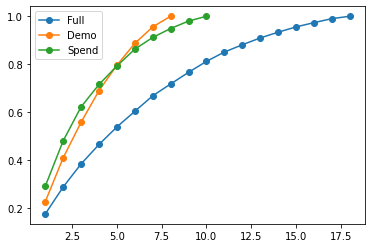

In [392]:
# create cumulative explained variance ratio plot to evaluate appropriate n_components

plt.figure(figsize=(6,4))
plt.plot(range(1,pca.shape[1]+1),std_evr.cumsum(), marker = 'o', label='Full')
plt.plot(range(1,pca_demo.shape[1]+1),demo_evr.cumsum(), marker = 'o', label='Demo')
plt.plot(range(1,pca_spend.shape[1]+1),spend_evr.cumsum(), marker = 'o', label ='Spend')
plt.legend()
plt.show()

In [393]:
# take first Principal components to 80-90%
pca = PCA(n_components=8).fit_transform(df_std)
pca_demo = PCA(n_components=6).fit_transform(df_demo)
pca_spend = PCA(n_components=6).fit_transform(df_spend)


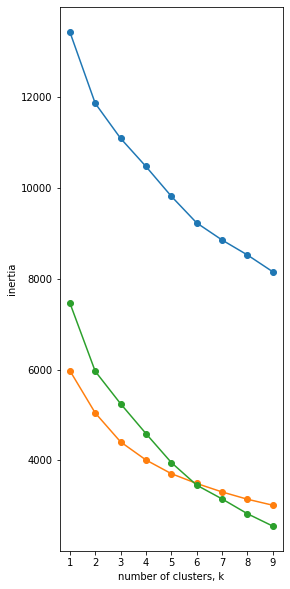

In [394]:
# create elbow plot to evaluate appropriate number of clusters

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

ks_demo = range(1, 10)
inertias_demo = []
for k in ks_demo:
    model = KMeans(n_clusters=k)
    model.fit(df_demo)
    inertias_demo.append(model.inertia_)

ks_spend = range(1, 10)
inertias_spend = []
for k in ks_spend:
    model = KMeans(n_clusters=k)
    model.fit(df_spend)
    inertias_spend.append(model.inertia_)

plt.figure(figsize=(4,10))    
    
plt.plot(ks, inertias, '-o', label='Full')
plt.plot(ks_demo, inertias_demo, '-o', label='Demo')
plt.plot(ks_spend, inertias_spend, '-o', label='Spend')

plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [406]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=123)

y_km = kmeans.fit_predict(df_std)
y_demo = kmeans.fit_predict(df_demo)
y_spend = kmeans.fit_predict(df_spend)

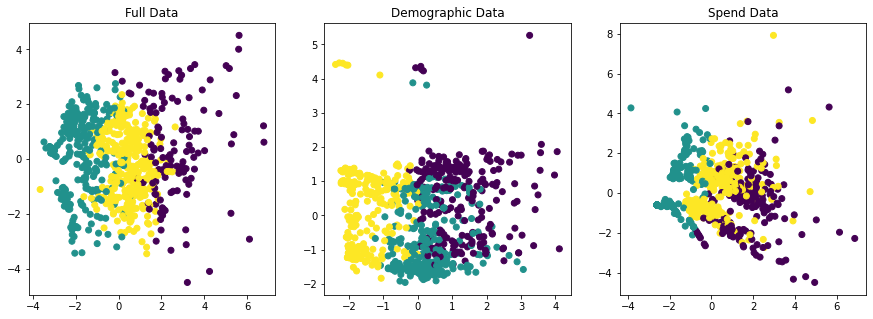

In [407]:
# plot kmeans clusters

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
   
ax1.scatter(pca[:, 0], pca[:, 1], c=y_km)
ax1.set_title('Full Data')
ax2.scatter(pca_demo[:, 0], pca_demo[:, 1], c=y_demo)
ax2.set_title('Demographic Data')
ax3.scatter(pca_spend[:, 0], pca_spend[:, 1], c=y_spend)
ax3.set_title('Spend Data')

plt.show()

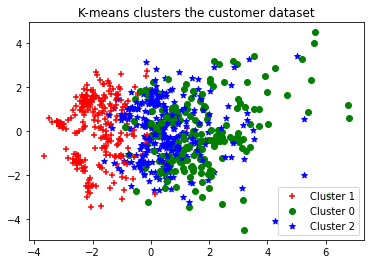

In [408]:
for i in range(0, pca_2d.shape[0]):
    if kmeans.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeans.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    elif kmeans.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
        
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 0','Cluster 2'])
plt.title('K-means clusters the customer dataset')
plt.show()

In [409]:
df_pca = pd.DataFrame(pca)
df_pca['y_km']=y_km

df_pca_demo = pd.DataFrame(pca_2d)
df_pca_demo['y_demo']=y_demo

df_pca_spend = pd.DataFrame(pca_2d)
df_pca_spend['y_spend']=y_spend

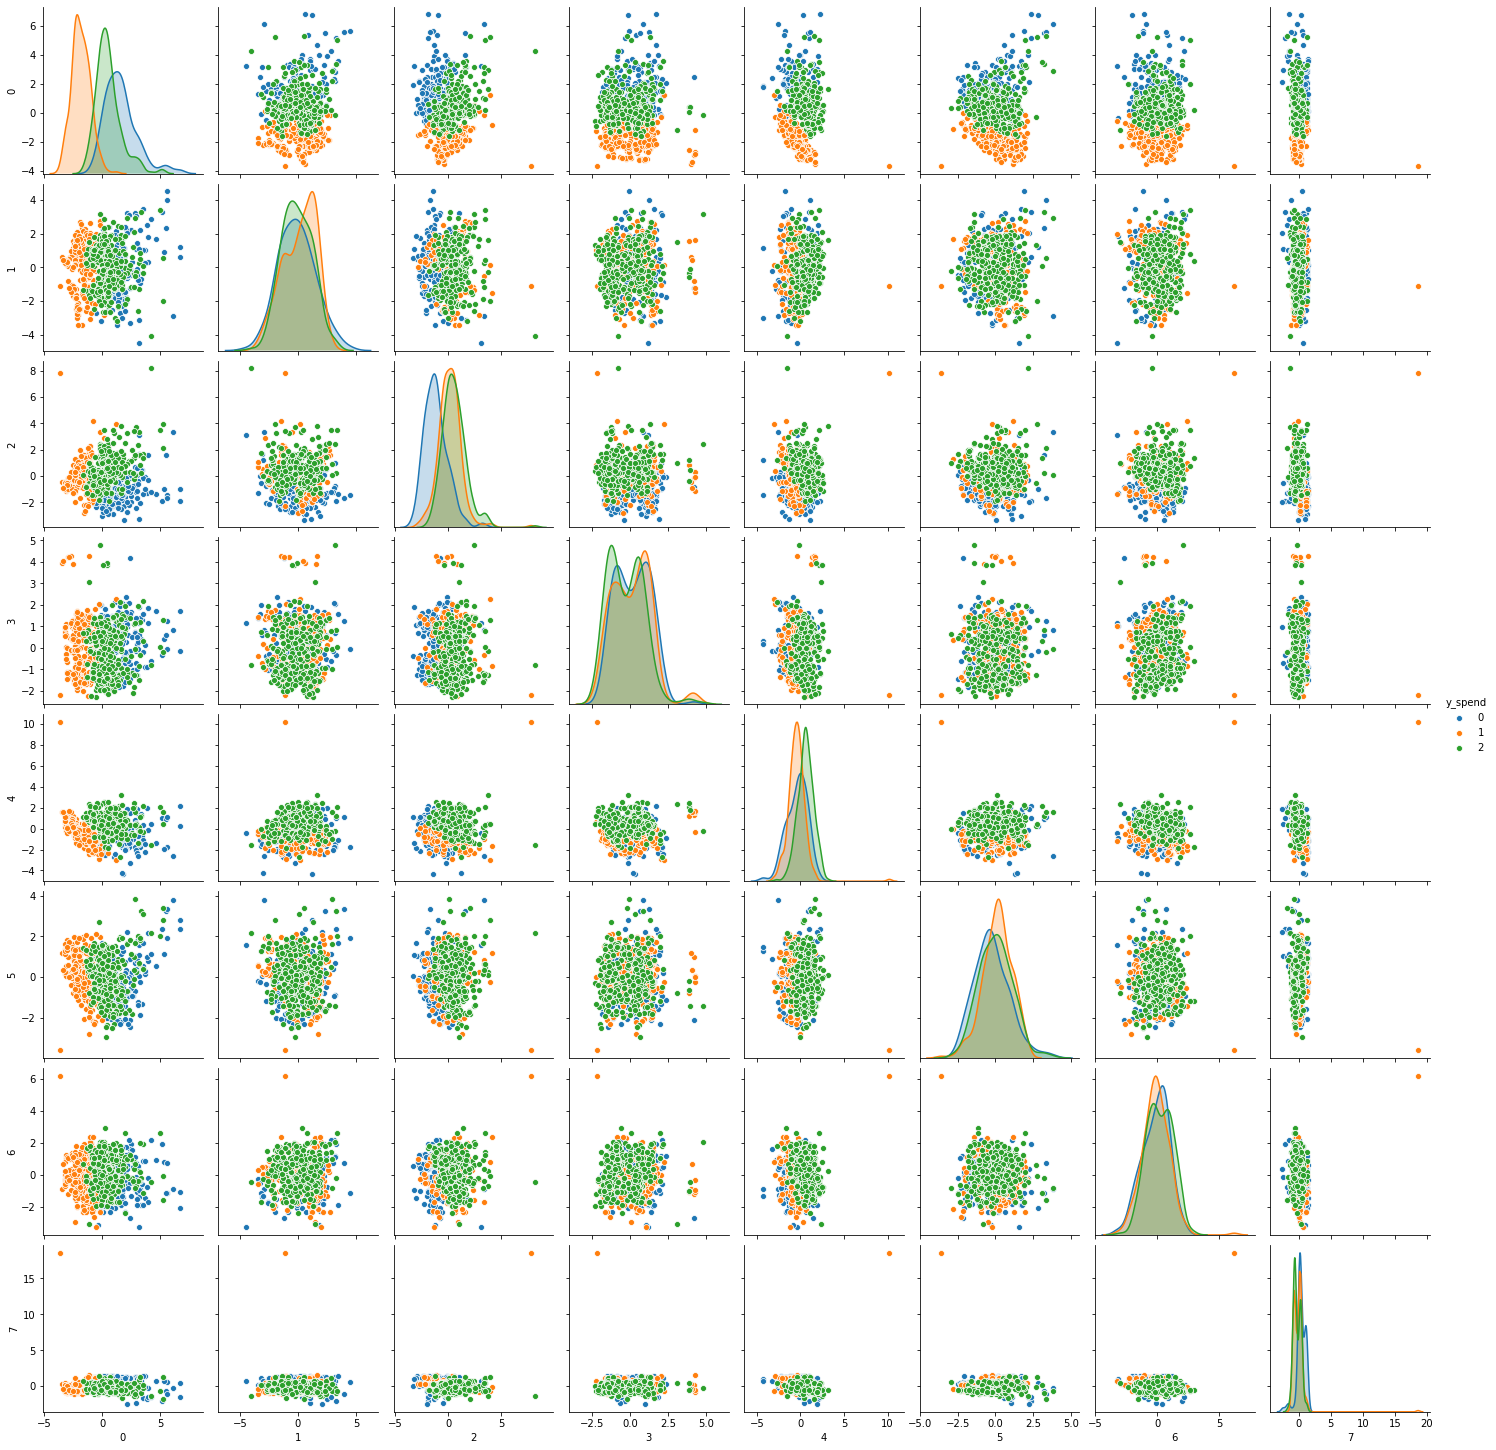

In [411]:
# look at pair plot of pca dataframes

sns.pairplot(df_pca_spend,hue='y_spend')

In [412]:
df_full = deepcopy(df_std)
df_full_demo = deepcopy(df_demo)
df_full_spend = deepcopy(df_spend)

df_full['segment_kmeans_pca'] = y_km
df_full['segment']=df_full['segment_kmeans_pca'].map({0:'first',1:'second',2:'third'})

df_full_demo['segment_kmeans_pca'] = y_demo
df_full_demo['segment']=df_full['segment_kmeans_pca'].map({0:'first',1:'second',2:'third'})

df_full_spend['segment_kmeans_pca'] = y_spend
df_full_spend['segment']=df_full['segment_kmeans_pca'].map({0:'first',1:'second',2:'third'})

In [413]:
df_full.head(10)

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,credit_limit,min_cheq_balance,min_sav_balance,M,Lat,Long,CC,cc_balance,SV,ending_balance,segment_kmeans_pca,segment
0,0.154185,0.184312,0.408539,0.258591,0.132149,0.318045,-1.603560,0.015394,-0.747104,-0.706945,-0.685160,1.127172,-0.185145,-0.924589,-1.295152,-0.608137,-1.136403,-0.426558,1,second
1,-0.726524,1.493070,-1.087435,-0.648298,0.132149,-1.066006,-0.012798,-0.307381,0.604087,1.540876,2.447120,1.127172,-0.610743,-1.088833,0.772110,0.660202,0.879970,-0.418803,0,first
2,-0.188366,-0.234490,1.530520,-0.648298,-0.989614,0.469779,0.187978,0.046814,-0.296707,-0.706945,-0.058704,-0.887176,-0.610743,-1.088833,0.772110,-0.373275,0.879970,-0.352837,2,third
3,1.123798,0.603115,-0.339448,-0.648298,-0.989614,1.070537,0.249755,0.166021,0.333848,-0.632018,-0.058704,-0.887176,-0.610743,-1.088833,0.772110,-0.608137,0.879970,-0.059979,2,third
4,0.983479,0.864867,1.904514,1.165479,2.375675,0.920392,0.450531,0.124181,2.270555,1.540876,-0.058704,-0.887176,0.727834,1.252063,0.772110,-0.551873,0.879970,-0.273737,0,first
5,-0.317419,0.550765,-0.339448,1.165479,0.132149,0.318045,-1.603560,0.015394,-0.747104,-0.706945,-0.685160,-0.887176,0.962032,0.531140,-1.295152,-0.608137,-1.136403,-0.426558,1,second
6,-1.024149,-1.386197,-1.087435,-0.648298,-0.989614,-0.700007,1.269078,-0.116081,-0.296707,1.540876,-0.058704,1.127172,-0.610743,-1.088833,0.772110,0.211082,0.879970,1.318923,2,third
7,-0.937227,1.911873,1.530520,-0.648298,0.132149,-1.290805,1.083747,-0.206708,0.604087,1.540876,2.447120,-0.887176,-3.172176,-3.185093,0.772110,1.849519,0.879970,-0.396844,0,first
8,0.775660,-0.077439,-1.087435,3.886146,2.375675,0.318045,-1.016677,0.015394,0.153690,-0.706945,-0.685160,-0.887176,-3.172176,-3.185093,0.772110,-0.608137,-1.136403,-0.426558,0,first
9,-0.590576,0.184312,0.782533,0.258591,0.132149,0.960740,1.099191,0.103610,0.604087,-0.632018,-0.058704,1.127172,-3.172176,-3.185093,0.772110,0.331564,0.879970,-0.067770,2,third


## Make radar chart

In [368]:
df_1 = df_full[df_full['segment'] == 'first']
df_2 = df_full[df_full['segment'] == 'second']
df_3 = df_full[df_full['segment'] == 'third']

df_1_d = df_full_demo[df_full_demo['segment'] == 'first']
df_2_d = df_full_demo[df_full_demo['segment'] == 'second']
df_3_d = df_full_demo[df_full_demo['segment'] == 'third']

df_1_s = df_full_spend[df_full_spend['segment'] == 'first']
df_2_s = df_full_spend[df_full_spend['segment'] == 'second']
df_3_s = df_full_spend[df_full_spend['segment'] == 'third']

In [369]:
df_1_mean = df_1.mean()
df_2_mean = df_2.mean()
df_3_mean = df_3.mean()

df_1_d_mean = df_1_d.mean()
df_2_d_mean = df_2_d.mean()
df_3_d_mean = df_3_d.mean()

df_1_s_mean = df_1_s.mean()
df_2_s_mean = df_2_s.mean()
df_3_s_mean = df_3_s.mean()

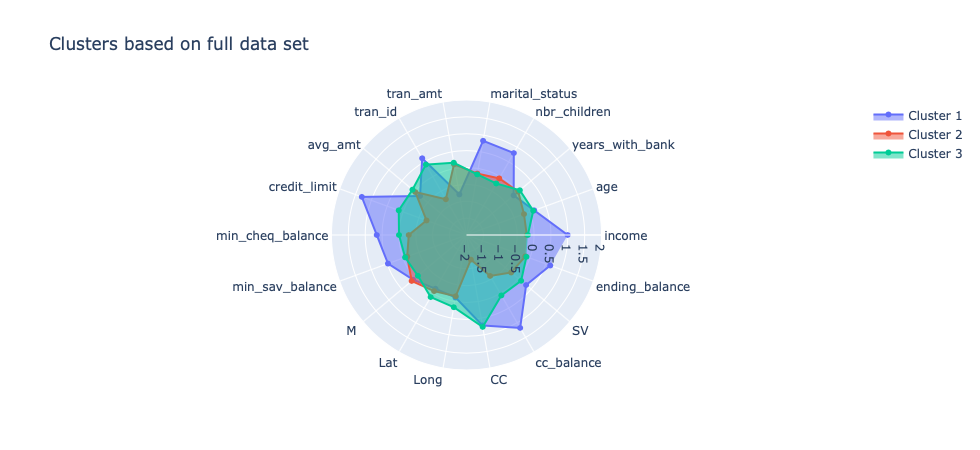

In [374]:
import plotly.graph_objects as go

categories = df_full.columns[:-2]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_1_mean,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=df_2_mean,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=df_3_mean,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 2]
    )),
  showlegend=True,
  title="Clusters based on full data set"
)

fig.show()

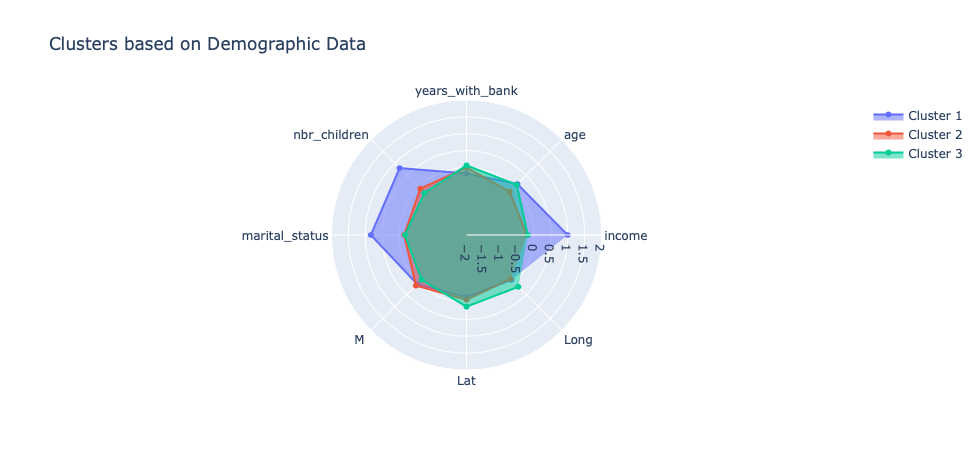

In [375]:
categories = df_full_demo.columns[:-2]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_1_d_mean,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=df_2_d_mean,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=df_3_d_mean,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 2]
    )),
  showlegend=True,
  title="Clusters based on Demographic Data"
)

fig.show()

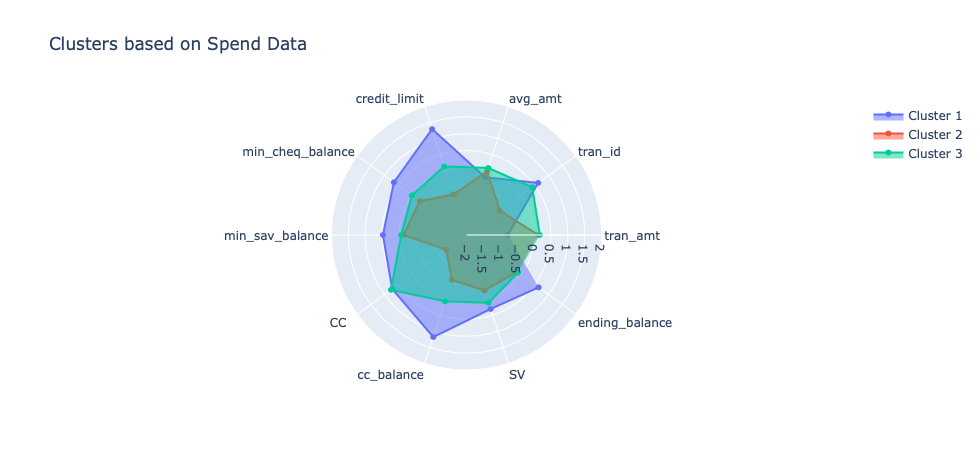

In [376]:
categories = df_full_spend.columns[:-2]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_1_s_mean,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=df_2_s_mean,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=df_3_s_mean,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 2]
    )),
  showlegend=True,
  title="Clusters based on Spend Data"
)

fig.show()

### visualize in 2D how our clusters are evolving in each iteration of KMeans (for at least 20 iterations).

In [377]:
kmeans = KMeans(n_clusters=3, random_state=123)
y_km = kmeans.fit_predict(df_std)

In [378]:
df_pca = df_pca[[0,1]]
X = np.array(df_pca)

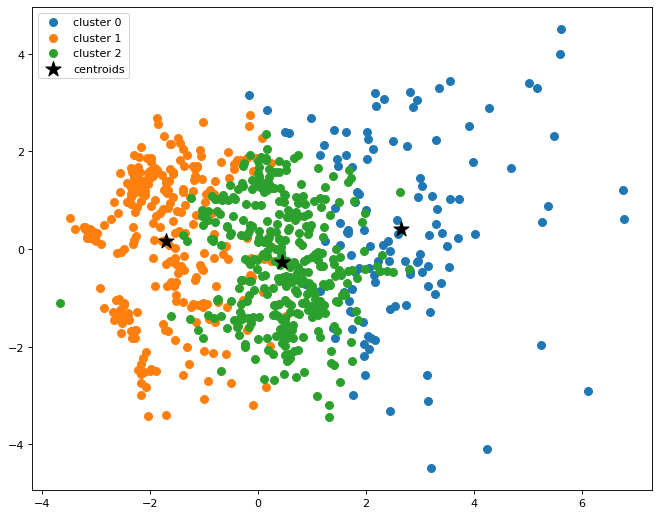

In [379]:
def show_plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    plt.figure(figsize=(10, 8), dpi=80)
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        
        plt.scatter(x,
                    y,
                    s=50,
                    marker='o',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=200,
                    label='centroids')

    plt.legend()
    plt.show()
    
    
    
show_plot_clusters(X, y_km, plt_cluster_centers= True)

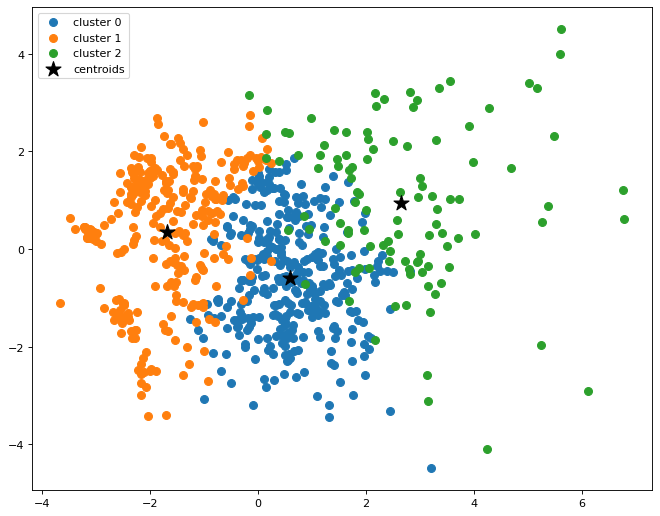

In [381]:
from IPython.display import clear_output

for i in range(1,20):
    clear_output()
    kmeans = KMeans(n_clusters=3, random_state=11, n_init=i)
    y_km = kmeans.fit_predict(df_std)
    show_plot_clusters(X, y_km, plt_cluster_centers= True)
    time.sleep(0.5)
   